In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
import statsmodels.discrete.discrete_model as sm
import sklearn.metrics as sklm
import random
import warnings 
import math
warnings.filterwarnings("ignore") # Ignore annoying warnings

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)

In [2]:
# y is True if any readmission variable is hot. It's NaN if all variables are null.
y = cdf[['READMISSION1-Yes','READMISSION-Yes']].any(1)
y[cdf[['READMISSION1-Yes','READMISSION-Yes']].isnull().all(1)] = np.nan

# Would like to drop rows with NaN y data
nanIdx = np.isnan(y).nonzero()
y = np.delete(y.ravel(), nanIdx ,axis=0)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

# Either drop or keep columns from cdf
dropOrKeep = False
if dropOrKeep:
    dropList = ['READMISSION-','READMISSION1-','REOPERATION-',\
                'REOPERATION1-','NWNDINFD-','WNDINFD-','DEHIS-','NDEHIS-',\
                'MORBPROB','NSUPINFEC-','SUPINFEC-','RETORPODAYS','OTHSYSEP',\
                'NOTHSYSEP-']
    colsToDrop = [colName for colName in cdf.columns if np.any([dropItem in colName for dropItem in dropList])]
    cdf = cdf.drop(colsToDrop,1)
    print('Dropped some variables: ')
    print(colsToDrop)
    # These are being dropped automatically by Imputer
    colsToDrop = [ 4,5,6,16,17,18,137,191,192,193,194,195,212,213,214,236,237,238,\
                  239,284,285,316,317,350,351,411,412,413,414,505,506,507,514,517]
    cdf = cdf.drop(cdf.columns[colsToDrop],axis=1)
    
else:
    # Dropping these columns is super-cumbersome. Let's find a list to keep
    # Need to add FNSTATUS1 and RBC
    keepList = ['SEX', 'RACE_NEW','ETHNICITY_HISPANIC','AGE','ANESTHES','HEIGHT','WEIGHT','DIABETES',\
                'SMOKE','PACKS','ETOH','DYSPNEA','FNSTATUS2','VENTILAT','HXCOPD','CPNEUMON',\
                'HXCHF','HXMI','PRVPCI','PRVPCS','HXANGINA','HYPERMED','HXPVD','RENAFAIL','DIALYSIS',\
                'CVA','DISCANCR','WNDINF','STEROID','WTLOSS','BLEEDDIS','PROPER30','ASACLASS',\
                'ASCITES','PRSODM','PRBUN','PRCREAT','PRALBUM','PRBILI','PRSGOT','PRALKPH','PRWBC'\
                'PRHCT','PRPLATE','PRPTT','PRINR','PRPT','PGY']
    colsToKeep = [colName for colName in cdf.columns if np.any([keepItem in colName for keepItem in keepList])]
    cdf = cdf[colsToKeep]

In [3]:
# Add an intercept
cdf['intercept'] = 1.0

# Impute missing data in cdf
colNames = cdf.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
imp.fit(cdf)
X = imp.transform(cdf)
cdf = pd.DataFrame(X, columns=colNames)

In [4]:
class gaussianKernel():
    
    def __init__(self, sampleInterval=1, sigma=1):
        self.sampleInterval = sampleInterval
        self.sigma = sigma

        nSigmas = 3
        nX = round(2*nSigmas*sigma/sampleInterval) + 1
        self.x = np.linspace(-nSigmas*sigma,nSigmas*sigma,nX)
        self.kernel = 1/(sigma*math.sqrt(2*math.pi))*np.exp(-self.x*self.x/(2*sigma*sigma))
        return 

    def plotKernel(self, axis):
    
        yScale = .25   
        xlims = axis.get_xlim()
        ylims = axis.get_ylim()

        # Plot the kernel on the plot
        plt.plot(self.x - self.x.min() + xlims[0], \
                 self.kernel*yScale*(ylims[1]-ylims[0])/self.kernel.max() + ylims[0],\
                 label='Kernel')
        return

In [38]:
# Alternative, make a lookup table predictor, and maximize the cross-validated ROC AUC
from sklearn.base import BaseEstimator
class smoothedLookupEstimator(BaseEstimator):
 
    def __init__(self, sigma=1, nBins=512, modelX=[], modelY=[]):
        self.sigma = sigma
        self.nBins = nBins
        self.modelX = modelX
        self.modelY = modelY
        self._estimator_type = "classifier"
        self.G = []
        self.bootedCI = False
        self.lowCI = []
        self.upCI = []
        return

    def fit(self, X, y):
        
        binEdges = np.linspace(X.min(),X.max()+1, self.nBins + 1)
        binWidth = binEdges[1] - binEdges[0]
        
        totalCounts, _ = np.histogram(X,bins=binEdges)
        targetCounts, _ = np.histogram(X[y==1],bins=binEdges)
        
        self.G = gaussianKernel( binWidth, self.sigma)
        smTotal = np.convolve(totalCounts,self.G.kernel,mode='same')
        smTarget = np.convolve(targetCounts,self.G.kernel,mode='same')
        
        self.modelX = binEdges[0:-1] + binWidth/2
        self.modelY = smTarget/smTotal
        return
        
    def score(self, X, y):
        predRes = self.predict_proba(X)
        rocAUC = sklm.roc_auc_score(y,predRes)
        return rocAUC
    
    def predict_proba(self, X):
        
        sizeX = len(X)
        sizeModel = len(self.modelX)
        bigX = X.reshape(1,-1).repeat(sizeModel,axis=0)
        bigModel = self.modelX.reshape(-1,1).repeat(sizeX,axis=1)
        
        idx = (np.abs(bigX - bigModel)).argmin(axis=0)
        return self.modelY[idx]
    
    def bootModelCI(self, X, y, nBoots, alpha):

        binEdges = np.linspace(X.min(),X.max()+1, self.nBins + 1)
        nSamp = len(y)
        
        print('Bootstrapping confidence intervals...')
        bootCurves = np.empty((nBoots,len(self.modelX)))
        for bootN in np.arange(nBoots):
            # Draw a collection of observations from the data with replacement
            sampIdx = [random.randint(0,nSamp-1) for n in np.arange(nSamp)]
            bootX = X[sampIdx]
            bootY = y[sampIdx]
          
            bootTotalCounts, _ = np.histogram(bootX,bins=binEdges)
            bootTargetCounts, _ = np.histogram(bootX[bootY==1],bins=binEdges)
            
            bSmTotal = np.convolve(bootTotalCounts,self.G.kernel,mode='same')
            bSmTarget = np.convolve(bootTargetCounts,self.G.kernel,mode='same')
            
            bootCurves[bootN,:] = bSmTarget/bSmTotal
    
        lciIdx = round(alpha/2*(nBoots-1))
        uciIdx = round((1-alpha/2)*(nBoots-1))
        bootCurves.sort(axis=0)
        self.lowCI = bootCurves[lciIdx,:]
        self.upCI  = bootCurves[uciIdx,:]
        self.bootedCI = True
        return 
    
    def plotModel(self,axis):
        plt.plot(self.modelX,self.modelY)
        if self.bootedCI:
            plt.fill_between(self.modelX, self.upCI, self.lowCI, color='gray', alpha=0.5)
        self.G.plotKernel(axis)
        plt.ylabel('P(y | X)')
        plt.xlabel('X')
        plt.show()
        return
    

In [36]:
X = cdf['AGE']

In [39]:
sle = smoothedLookupEstimator(nBins=512)
tuned_parameters = [{'sigma': np.logspace(-1,1.3,20,base=10)}]
gscv = GridSearchCV(sle,tuned_parameters,cv=10,verbose=1)
gscv.fit(X, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    4.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=smoothedLookupEstimator(modelX=[], modelY=[], nBins=512, sigma=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'sigma': array([  0.1    ,   0.13215,   0.17462,   0.23076,   0.30494,   0.40296,
         0.5325 ,   0.70367,   0.92987,   1.22878,   1.62378,   2.14575,
         2.83551,   3.747  ,   4.9515 ,   6.54319,   8.64654,  11.42601,
        15.09897,  19.95262])}],
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

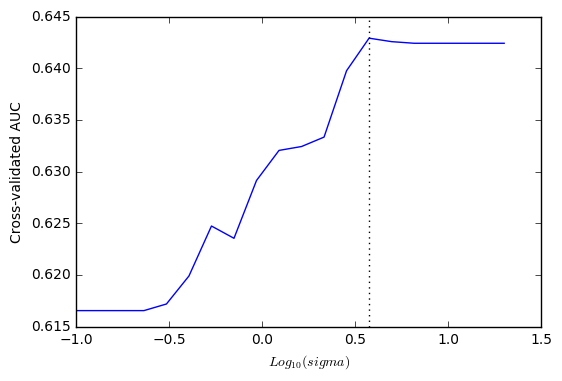

Best sigma = 3.747


In [40]:
gscv.grid_scores_
means = [mean_score for params, mean_score, scores in gscv.grid_scores_]
Cs = [params['sigma'] for params, mean_score, scores in gscv.grid_scores_]
plt.plot(np.log10(Cs), means)
bestC = gscv.best_params_['sigma']
ylims = plt.gca().get_ylim()
plt.plot(np.log10([bestC, bestC]),ylims,color='k',ls=':')
plt.ylim(ylims)
plt.xlabel('$Log_{10}(sigma)$')
plt.ylabel('Cross-validated AUC')
plt.show()
print('Best sigma = %.3f' % bestC)

Bootstrapping confidence intervals...


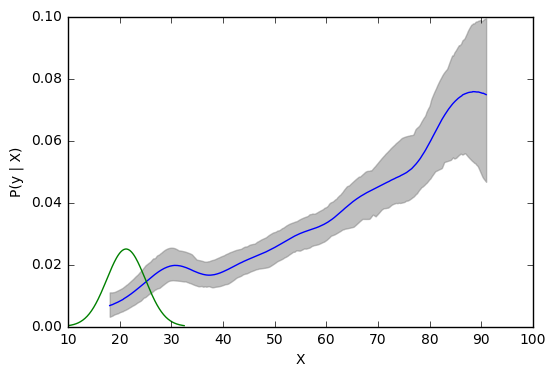

In [41]:
sle = smoothedLookupEstimator(sigma=bestC)
sle.fit(X,y)
sle.bootModelCI(X,y,200,0.05)
sle.plotModel(plt.gca())